Magroove Data Science Test
=======================

### Intro
The goal of this test is to access your ability to use data science to tackle a real life issue. Because the nature of the issue is just so complex, we do not expect your solution to be definitive or highly performant - we actually don’t really care about the accuracy of your results at all. What we really care about is your thought process or the way you take an issue, distill it into something solvable by a machine and turn all that into code. As you may imagine at this point, this test will revolve around a machine learning problem - a classification one to be more specific, so let’s get to it.

### The Problem
When uploading an album to digital streaming platforms (DPSs) like Spotify, Apple or so on, it is important that all the metadata that goes with that album to be accurate. Metadata includes basic information like the album name, the year when it was recorded, the artists involved in the tracks and much more. In this exercise we are particularly interested in a specific element of the metadata - language.

Language is an important piece of metadata as it helps the DPSs recommend a given album to listeners that understand that language and will most likely appreciate it. Because of that, DSPs are quite strict with the correct language being assigned when receiving an album.

However, it does occur quite frequently for our users to incorrectly fill the language field in our form when submitting an album, which later leads to conflicts between the given user, our company and the DSPs. The goal of this test then is to work on a solution for a simplified version of such problem.

Together with this description you will find two files - dataset-hindi.csv and dataset-spanish.csv. The names are quite intuitive, each contains metadata from albums we already distribute and that we know their metadata are either written in Spanish or Hindi. Each CSV contains three columns - artist_name, release_name and song_name. Even though the names are rather intuitive, you should pay attention to the fact that the columns artist_name and release_name tend to have repeated entries as the same artist can have several albums and an album can have several songs.

**Your goal then is to create a model to classify future metadata as either written in Spanish or Hindi.**

### The deliverables
We expect to receive from you a single python script (run.py) and a requirements (requirements.txt) file listing all the dependencies to run it. Your script should be written using Python 3.x and it should output a model we could later use for inference in a production-like environment. You can use any packages or libraries you want as long as you don’t use any pre-trained model. You are also forbidden to use third party APIs or services for language inference like AWS Comprehend or GCP Translation. Your single script should contain everything from data cleaning and preprocessing all the way to model training and inference.

### Evaluation and final thoughts

Again, even though accuracy is always a good metric, our primary focus will definitely not be performance (we would be running a Kaggle competition if it was =) ). Our attention will be on the logic you used to try and solve the issue and how it translated into code. So don’t worry if your model performs poorly at the end - we would choose nine out of ten times a poor model performance with a smart approach and attempt to solve the problem in question.

And finally, don’t hesitate to get in touch if you have any questions, doubts or simply need a kick start. Here at Magroove we have a strong culture of helping each other out - so you can definitely count on us - and we promise that any calls for help will not affect your evaluation at all. In the end solving challenging problems is mostly about asking the right questions, so well thought questions are more than welcome. So good luck with your test and keep us in the loop!


##  Visualização dos Dados

In [1]:
import pandas as pd
import numpy as np
import unidecode
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer # (converter as colunas em um array)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Function to Reduce repeated characters and punctuations
def reducing_incorrect_character_repeatation(text):
    """
    This Function will reduce repeatition to two characters 
    for alphabets and to one character for punctuations.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Finally formatted text with alphabets repeating to 
        two characters & punctuations limited to one repeatition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Reallyy, Greeaatt !?.;:)
    
    """
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted

## Análise Exploratória

In [3]:
# Importando os dados
df_sp = pd.read_csv('dataset-spanish.csv', header = 0)
df_hi = pd.read_csv('dataset-hindi.csv', header = 0)

In [4]:
# Visualização dos dados
df_sp.sample(5)

,artist_name,release_name,song_name
2614,Esteban Estevez,Senderos,"Como, Donde Y Cuando"
3480,CNV,Identidad,enero
417,Tommy G,Baby Baby Baby,Baby Baby Baby
4347,El Soldado De Jesus Oficial,Hay Unos,me enamore de ti
1508,Djkeivis,24 Rosas,24 Rosas


In [5]:
# Visualização dos dados
df_hi.sample(5)

,artist_name,release_name,song_name
38,Atul Anand,Ai Khuda,Ai Khuda
704,Visual Chinmay,Dildara,Dildara
3002,Nabeel Khan,Kesariya Balam (Sarangi),Kesariya Balam (Sarangi)
2972,Devansu Rathva,Jethalala,Bhide
4122,Jaikant Bhardwaj,Kabhi Kabhi,Kabhi Kabhi


In [6]:
# Checking the dataset lenght
print(f'Spanish dataset length: {len(df_sp)} \nHindi dataset lenght: {len(df_hi)}')

Spanish dataset length: 5000 
Hindi dataset lenght: 5000


In [7]:
# Describe dos dados
df_sp.describe()


,artist_name,release_name,song_name
count,5000,4999,4999
unique,1415,1870,4702
top,Various,Cumbias Sonideras,Title Error
freq,134,134,24


In [8]:
df_hi.describe()

,artist_name,release_name,song_name
count,5000,5000,4997
unique,2436,4034,4616
top,Visual Chinmay,Vibeee:),Title Error
freq,134,59,33


## Data Cleaning

> Before starting the data cleaning process, I'll add the column 'Idiom' in the datasets so I can already concatenate them to make the cleaning for the whole dataset

In [9]:
# Adding a 'Idiom' column
df_sp['Idiom'] = 'Spanish'
df_hi['Idiom'] = 'Hindi'

In [10]:
# Concatenating the datasets
df = pd.concat([df_sp, df_hi])
len(df)

10000

In [11]:
print(df.duplicated().sum())

154


In [12]:
# Dropping duplicated rows
df.drop_duplicates(inplace= True)

In [13]:
# Checkin missing values
df.isna().sum()

artist_name     0
release_name    1
song_name       4
Idiom           0
dtype: int64

In [14]:
# Dropping the rows with missing values
df.dropna(inplace=True)

In [15]:
# Checking dataset lenght after dropping the duplications for the spanish and the hindi (so we can see if it's still balanced)
print(f"Spanish dataset length: {len(df[(df.Idiom == 'Spanish')])} \nHindi dataset lenght: {len(df[(df.Idiom == 'Hindi')])}")

Spanish dataset length: 4935 
Hindi dataset lenght: 4906


In [16]:
df.describe()

,artist_name,release_name,song_name,Idiom
count,9841,9841,9841,9841
unique,3843,5891,9299,2
top,Various,Cumbias Sonideras,Title Error,Spanish
freq,134,134,31,4935


In [17]:
# Taking a deep look into the variables to clean it properly
df['song_name'].value_counts()

Title Error              31
Intro                     9
TITLE_ERROR               7
Contigo                   6
Ranjha                    5
                         ..
Me Llevo a Las Gyales     1
Yuca                      1
Cash Out                  1
Lunes Rahib               1
The Devue                 1
Name: song_name, Length: 9299, dtype: int64

In [18]:
# I'll remove the rows with Title Error (and TITLE_ERROR) and also the Intro songs, since it doesn't mean much about the idiom of the song (which is what we are looking for in this project)
df = df[(df.song_name != 'Title Error') & (df.song_name != 'TITLE_ERROR') & (df.song_name.str.startswith('Intro') == False)]

In [19]:
df.describe()

,artist_name,release_name,song_name,Idiom
count,9781,9781,9781,9781
unique,3822,5864,9283,2
top,Various,Cumbias Sonideras,Contigo,Spanish
freq,134,134,6,4903


In [20]:
# Removing possible double whitespace in the text
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = re.sub(r'\s+', ' ', df[(df.columns.values[i])].values[j])

In [21]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
1977,Lemon X,Hey Girl,Hey Girl,Hindi
3813,Udit Narayan,Udit Narayan Songs,Dhire Dhire Aap Mere,Hindi
1450,Iteo,"Pala, Olla","Pala, Olla",Spanish
3168,Kanha Uk 08,Poison,Poison,Hindi
2399,Sakubu,Reshoma Ka Matla,Reshoma Ka Matla,Hindi


> O que fazer com os registro que possuem grande quantidade de valores repetidos como em 'release_name' e 'artist_name' ???

## Pré-Processing

### Removing accented characters

In [22]:
# Removing accented characters
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = unidecode.unidecode(df[(df.columns.values[i])].values[j])

In [23]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
2475,Abhi,Country 0.2,Country 0.2 Music,Hindi
4780,Various,Cumbias Sonideras,El Amor De Mi Nena - Que Nota,Spanish
1749,Miti Miti,Miti Miti '88,Por Ti,Spanish
4496,Day Tripper,Ahora O Nunca,Sonico,Spanish
231,Zevna,Barbarroja,Contemplacion,Spanish


### Converting the dataset to lowercase

In [24]:
# Converting the dataset to lowercase
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = (df[(df.columns.values[i])].values[j]).lower()

In [25]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
2024,shailesh saraf,ajab saje he mahakali mor pendrawali - ajb saa...,ajab saje he mahakali mor pendrawali - ajb saa...,hindi
3953,manorth,descomposicion,murder,spanish
372,julion alvarez y su norteno banda,en vivo,manos arriba (en vivo),spanish
1738,doctor shail,inception,gama male,hindi
4579,drinkover,arquitecto de ilusiones,arquitecto de ilusiones,spanish


### Reducing repeated characters and punctuations

In [26]:
# Reducing repeated characters and punctuations
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = reducing_incorrect_character_repeatation(df[(df.columns.values[i])].values[j])

In [27]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
2402,emma,el portal magico,mundo de los suenos,spanish
4365,shikari,kagazi lavs,kagazi lavs,hindi
1719,el coyote y su banda tierra santa,la carretera del amor,linda doctora,spanish
2531,lummy,"como tu quieras""""","como tu quieras"" lummy""",spanish
4002,diego (treinta doble d),con calma,con calma,spanish


> *I still need to do more cleaning regarding this part. We have a lot of songs starting with " . " or blank space*

### Removing Special Characters

In [28]:
# Removing Special Characters and also numbers(since the numbers doesn't give any hint regarding idiom)
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = re.sub("[.,;/0-9!?¿%@|~'#+:()-]", '', df[(df.columns.values[i])].values[j])

In [29]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
2040,beshav,abhikaran,abhikaran,hindi
3752,x rhymer,baby i told you,baby i told you mastered,hindi
3907,jugglerboy,corazon duro,corazon duro,spanish
4678,trio samaritano,solo un poco mas,la creacion,spanish
2773,leiss z,leiss z rkt,leiss z rkt,spanish


In [30]:
# Visualizing data 
df.sort_values('song_name')

,artist_name,release_name,song_name,Idiom
3205,walther pro,resonancia,,spanish
1316,cxcile,,,spanish
671,zevna javi cheuke,jardin botanico,,spanish
4036,zanmala,,,spanish
1908,tchad,ivory waali irony,,hindi
...,...,...,...,...
1792,d i c,zona sur rkt,zona sur rkt,spanish
585,soledad bravo live dec,lost and found latin music tapes,zorongo,spanish
2510,zeta,zta music sessions vol,zta music sessions vol,spanish
1791,bsk brothers,absolute desi vol,zul zul vahe,hindi


In [31]:
# Remove the rows where we got empty values after the pre-processing and couldn't be removed by .dropna()
df[(df.song_name == '')]

,artist_name,release_name,song_name,Idiom
671,zevna javi cheuke,jardin botanico,,spanish
1316,cxcile,,,spanish
1998,oniricboii,,,spanish
2348,seven,,,spanish
2903,j boi,,,spanish
2921,jadix,tena,,spanish
3205,walther pro,resonancia,,spanish
4028,ruido julio,,,spanish
4036,zanmala,,,spanish
1908,tchad,ivory waali irony,,hindi


In [32]:
df = df[(df.song_name != '') & (df.release_name != '') & (df.artist_name != '')]

In [33]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
4801,various,cumbias sonideras,cumbia callejera,spanish
1089,bad bunny x jhay cortez,dakiti,bad bunny x jhay cortez dakiti alberto morecalde,spanish
4698,ace,riha,aud wa,hindi
65,toy toy rana,kisi ke bure waqt mein uska sath do,kisi ke bure waqt mein uska sath do,hindi
307,diksha chaubey,walking home,kho gaye hum kahan,hindi


> We could see that some albuns had the 'vol' in its end (indicating which volum it is). Since it's a generic word, it won't help to keep them in our dataset. Let's remove the word then.
 Now that we took the numbers out, lets see how many we have left

In [34]:
print(df['release_name'].str.endswith('vol ').sum())
print(df['release_name'].str.endswith('vol').sum())

49
49


In [35]:
# Removing 'vol' and 'vol ' in the end of the albuns
for i in range(0, len(df)):
    if df.release_name.str.endswith('vol ').values[i]:
        df.release_name.values[i] = df.release_name.values[i].replace('vol ', '')
    elif df.release_name.str.endswith('vol').values[i]:
        df.release_name.values[i] = df.release_name.values[i].replace('vol', '')

In [36]:
# Checking if they were fully removed.
print(df['release_name'].str.endswith('vol ').sum())
print(df['release_name'].str.endswith('vol').sum())

0
0


In [37]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
4177,eliceboy,khoya tune mujhko,khoya tune mujhko,hindi
975,anurag bambori,malwa aadesh ho,malwa aadesh ho,hindi
2609,kiara,besharmi ki height slowed reverb,besharmi ki height slowed reverb,hindi
2378,nacho y los igualados,nacho y los igualados,vuela libre,spanish
196,ricardo j escajadillo,ricodillo,yendo pal norte,spanish


In [38]:
# Transformando a variável target 'Idiom' and 0 e 1 ("0" -> 'hindi ; "1" -> spanish)
df['Idiom'] = np.where((df['Idiom']) == 'spanish', 1,0)

In [39]:
df['Idiom'].value_counts()

0    4875
1    4873
Name: Idiom, dtype: int64

In [40]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
3981,latan villegas avelino,quiero verte de nuevo,quiero verte de nuevo,1
1637,igor lavrov,miniaturas revividas de carlos figueredo,corriente,1
4468,ashna v raju,abhi to mile bepannah,bepanahh,0
4464,fakka dj,plato music,sonreir vol,1
2795,anand ghosh,my melodious journey,na tum jaano hum,0


## Model Training

### Train and Test Dataset

In [41]:
x = (df.drop(['Idiom'], axis = 1)) # predictors
y = (df['Idiom']) # target

In [42]:
type(x)

pandas.core.frame.DataFrame

In [43]:
cv = CountVectorizer()
ct = make_column_transformer((cv,'artist_name'),(cv,'song_name'),(cv,'release_name'))
X = ct.fit_transform(x)

In [44]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

c:\Users\rafajovelho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


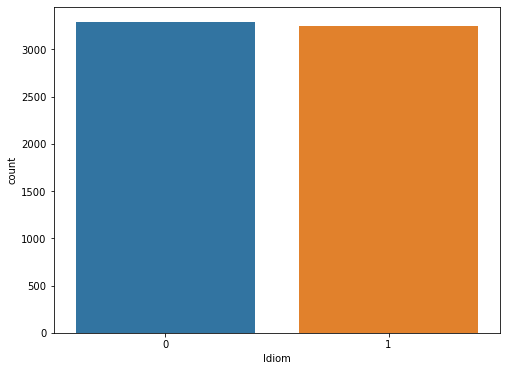

In [45]:
# Verifying if the variable is balanced
plt.figure(figsize = (8,6))

ax = sns.countplot(y_train)

In [46]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

## Score

In [47]:
score = model.score(X_test, y_test)
print(score)

0.9564811936586882


In [48]:
# Confusion Matrix
predictions = model.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))

[[1509   78]
 [  62 1568]]


In [49]:
# Precision
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1587
           1       0.95      0.96      0.96      1630

    accuracy                           0.96      3217
   macro avg       0.96      0.96      0.96      3217
weighted avg       0.96      0.96      0.96      3217



I'll be testing the same model, but now using only the "song_name" as predictor variable.

In the other 2 columns we have many values repeating (we have one album for more than 10 songs for example). So I guess it will be a more generic model if we use it with the song_name only

### Train and Test Dataset

In [50]:
x = np.array((df['song_name'])) # predictors
y = np.array((df['Idiom'])) # target

In [51]:
cv = CountVectorizer()
X = cv.fit_transform(x)

In [52]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

c:\Users\rafajovelho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


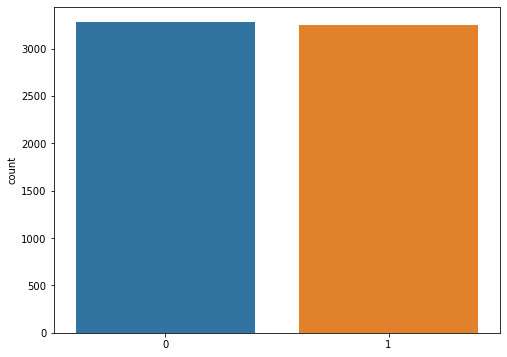

In [53]:
# Verifying if the variable is balanced
plt.figure(figsize = (8,6))

ax = sns.countplot(y_train)

In [54]:
model1 = MultinomialNB()
model1.fit(X_train, y_train)

MultinomialNB()

### Score

In [55]:
score = model1.score(X_test, y_test)
print(score)

0.8874728007460366


In [56]:
predictions = model1.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1311  286]
 [  76 1544]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1597
           1       0.84      0.95      0.90      1620

    accuracy                           0.89      3217
   macro avg       0.89      0.89      0.89      3217
weighted avg       0.89      0.89      0.89      3217



We got a worse result using only the 'song_name' variable. But it actually might be better for futures datasets, since for this one we have a lot of repeated values for albuns and artists name.

### KNN

In [57]:
x = (df.drop(['Idiom'], axis = 1)) # predictors
y = (df['Idiom']) # target

In [58]:
cv = CountVectorizer()
ct = make_column_transformer((cv,'artist_name'),(cv,'song_name'),(cv,'release_name'))
X = ct.fit_transform(x)

In [59]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [60]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [61]:
score = model2.score(X_test, y_test)
print(score)

0.8234379857009636


In [62]:
predictions = model2.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1090  523]
 [  45 1559]]
              precision    recall  f1-score   support

           0       0.96      0.68      0.79      1613
           1       0.75      0.97      0.85      1604

    accuracy                           0.82      3217
   macro avg       0.85      0.82      0.82      3217
weighted avg       0.85      0.82      0.82      3217



Now using only song_name as predictor

In [63]:
x = np.array((df['song_name'])) # predictors
y = np.array((df['Idiom'])) # target

In [64]:
cv = CountVectorizer()
X = cv.fit_transform(x)

In [65]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [66]:
# Trainning model
model3 = KNeighborsClassifier()
model3.fit(X_train, y_train)

KNeighborsClassifier()

In [67]:
# Score
score = model3.score(X_test, y_test)
print(score)

0.7556729872552067


In [68]:
predictions = model3.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[ 858  740]
 [  46 1573]]
              precision    recall  f1-score   support

           0       0.95      0.54      0.69      1598
           1       0.68      0.97      0.80      1619

    accuracy                           0.76      3217
   macro avg       0.81      0.75      0.74      3217
weighted avg       0.81      0.76      0.74      3217

